In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from plot_utils import plotCategoricalPerformance
import os
import seaborn as sns
import pandas as pd
from tf_util.families import family_from_str
from plot_util import EFN_model_df, find_last_ind, get_latest_diagnostics
from efn_util import setup_IO, find_convergence, model_opt_hps

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

basedir = '/Users/sbittner/Documents/efn/';
dir_str = 'dim_sweep'


In [2]:
exp_fam = 'dirichlet';

datadir = '/Users/sbittner/Documents/efn/results/dim_sweep/';
Ds = [25];
give_hint = False;
scatterR2ylim = [0, 1];
errovbarR2ylim = scatterR2ylim;
scatterKLylim = [0, 1];
errorbarKLylim = scatterKLylim;
    
num_Ds = len(Ds);
        
num_ds = 10;
K = 100;
M = 1000;




In [5]:
diagnostic_list = [];
Ds_list = [];
rs = 0;
wsize = 50;
delta_thresh = 1e-10;

max_iters = 1000000;
min_iters = 50000;
check_rate = 100;
max_checks = np.int(max_iters // check_rate);
min_checks = np.int(min_iters // check_rate);

model = 'EFN1';
_num_ds = num_ds;

Ls = [1, 5];
num_Ls = len(Ls);

mean_elbos_all = [];
std_elbos_all = [];
mean_R2s_all = [];
std_R2s_all = [];
mean_KLs_all = [];
std_KLs_all = [];
final_inds_all = [];
for ii in range(num_Ls):
    L = Ls[ii];
        
    elbos_all = np.zeros((num_Ds, _num_ds, K));
    R2s_all = np.zeros((num_Ds, _num_ds, K));
    KLs_all = np.zeros((num_Ds, _num_ds, K));
    
    mean_elbos = np.zeros((num_Ds, _num_ds, max_checks));
    std_elbos = np.zeros((num_Ds, _num_ds, max_checks));
    mean_R2s = np.zeros((num_Ds, _num_ds, max_checks));
    std_R2s = np.zeros((num_Ds, _num_ds, max_checks));
    mean_KLs = np.zeros((num_Ds, _num_ds, max_checks));
    std_KLs = np.zeros((num_Ds, _num_ds, max_checks));
    final_inds = np.zeros((num_Ds, _num_ds));
    for i in range(num_Ds):
        D = Ds[i];
        
        if (D >= 20):
            min_iters = 100000;
        else:
            min_iters = 50000;

        fam_class = family_from_str(exp_fam);
        family = fam_class(D);
        D_Z, num_suff_stats, num_param_net_inputs, num_T_x_inputs = family.get_efn_dims('eta', give_hint);

        
        TIF_flow_type, nlayers, scale_layer, lr_order = model_opt_hps(exp_fam, D);
        param_net_hps = {'L':L};
        
        for ds in range(_num_ds):
            flow_dict = {'latent_dynamics':None, \
                         'scale_layer':scale_layer, \
                         'TIF_flow_type':TIF_flow_type, \
                         'repeats':nlayers};
            dist_info = {'dist_seed':ds};
            model_dir = setup_IO(family, model, dir_str, 'eta', K, M, flow_dict, \
                                         param_net_hps, give_hint, rs, dist_info);
            savedir = basedir + model_dir;
            fname = savedir + 'results.npz';
            try:
                npzfile = np.load(fname);
            except:
                print('Error! Issue reading %s' % model_dir);
                continue

            test_elbos = npzfile['test_elbos'];
            last_ind = find_last_ind(test_elbos);
            mean_test_elbos = np.mean(test_elbos, 1);
            ind = find_convergence(mean_test_elbos, last_ind+1, wsize, delta_thresh);
            if (ind is None or (not npzfile['converged'])):
                print('Hasnt converged: %s' % fname);
                continue;
            else:
                ind = max(ind, min_checks);
                final_inds[i, ds] = ind;
                print('%s was fine' % model_dir);
            
            diagnostic_str = 'train' if (model == 'EFN1') else 'test';
            mean_elbos[i,ds,:ind] = np.mean(npzfile['%s_elbos' % diagnostic_str], 1)[:ind];
            std_elbos[i,ds,:ind] = np.std(npzfile['%s_elbos' % diagnostic_str], 1)[:ind];
            mean_R2s[i,ds,:ind] = np.mean(npzfile['%s_R2s' % diagnostic_str], 1)[:ind];
            std_R2s[i,ds,:ind] = np.std(npzfile['%s_R2s' % diagnostic_str], 1)[:ind];
            mean_KLs[i,ds,:ind] = np.mean(npzfile['%s_KLs' % diagnostic_str], 1)[:ind];
            std_KLs[i,ds,:ind] = np.std(npzfile['%s_KLs' % diagnostic_str], 1)[:ind];
            
            elbos, R2s, KLs, status = get_latest_diagnostics(fname, is_train=(model=='EFN1'), ind=ind);
            elbos_all[i, ds,:] = elbos;
            R2s_all[i, ds,:] = R2s;
            KLs_all[i, ds,:] = KLs;
    diagnostic_list.append([elbos_all, R2s_all, KLs_all]);
    Ds_list.append(np.tile(np.expand_dims(np.expand_dims(np.array(Ds), 1), 2), [1, _num_ds, K]));
    
    mean_elbos_all.append(mean_elbos);
    std_elbos_all.append(std_elbos);
    mean_R2s_all.append(mean_R2s);
    std_R2s_all.append(std_R2s);
    mean_KLs_all.append(mean_KLs);
    std_KLs_all.append(std_KLs);
    final_inds_all.append(final_inds);

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sbittner/Library/Python/3.6/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


results/dim_sweep/EFN1_dirichlet_u_0.5to5.0_D=25_flow=25P_L=1_ds=0_rs=0/ was fine
results/dim_sweep/EFN1_dirichlet_u_0.5to5.0_D=25_flow=25P_L=1_ds=1_rs=0/ was fine
results/dim_sweep/EFN1_dirichlet_u_0.5to5.0_D=25_flow=25P_L=1_ds=2_rs=0/ was fine
results/dim_sweep/EFN1_dirichlet_u_0.5to5.0_D=25_flow=25P_L=1_ds=3_rs=0/ was fine
results/dim_sweep/EFN1_dirichlet_u_0.5to5.0_D=25_flow=25P_L=1_ds=4_rs=0/ was fine
results/dim_sweep/EFN1_dirichlet_u_0.5to5.0_D=25_flow=25P_L=1_ds=5_rs=0/ was fine
results/dim_sweep/EFN1_dirichlet_u_0.5to5.0_D=25_flow=25P_L=1_ds=6_rs=0/ was fine
results/dim_sweep/EFN1_dirichlet_u_0.5to5.0_D=25_flow=25P_L=1_ds=7_rs=0/ was fine
results/dim_sweep/EFN1_dirichlet_u_0.5to5.0_D=25_flow=25P_L=1_ds=8_rs=0/ was fine
results/dim_sweep/EFN1_dirichlet_u_0.5to5.0_D=25_flow=25P_L=1_ds=9_rs=0/ was fine
Hasnt converged: /Users/sbittner/Documents/efn/results/dim_sweep/EFN1_dirichlet_u_0.5to5.0_D=25_flow=25P_L=5_ds=0_rs=0/results.npz
results/dim_sweep/EFN1_dirichlet_u_0.5to5.0_D=25_

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 864x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


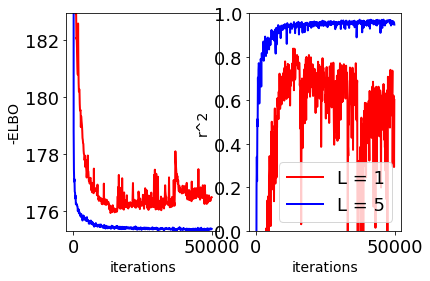

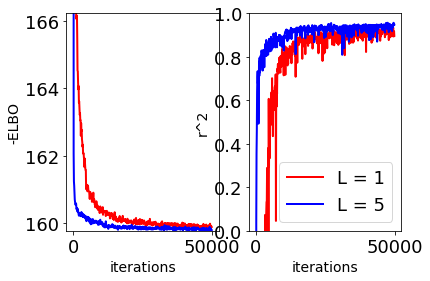

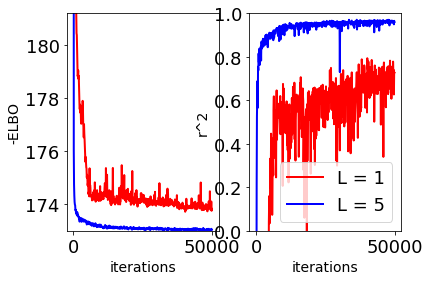

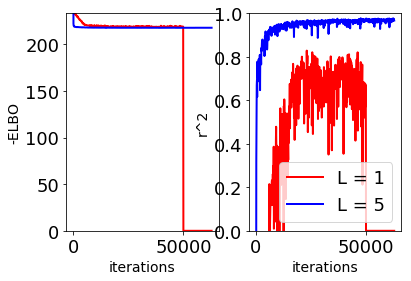

<Figure size 432x288 with 0 Axes>

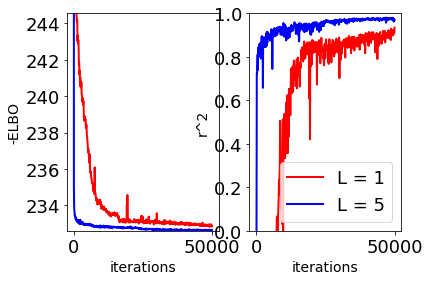

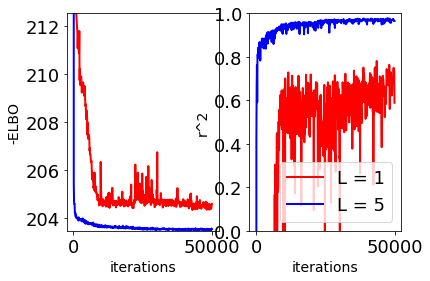

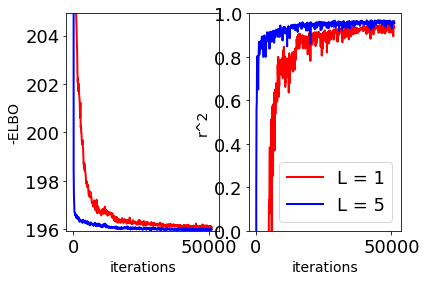

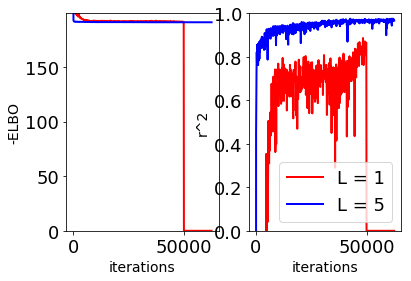

In [16]:
colors = ['r', 'b'];
fontsize = 14;
plt.figure(figsize=(12,5));

legendstrs = [];
for ii in range(num_Ls):
    legendstrs.append('L = %d' % Ls[ii]);

for i in range(num_Ds):
    D = Ds[i];
    for ds in range(_num_ds):
        plt.figure();
        if (ds==0 or ds==5):
            continue;
        final_ind = int(final_inds[i,ds]);
        its = np.arange(0, check_rate*final_ind, check_rate);
        
        min_vals_elbo = [];
        max_vals_elbo = [];
        min_vals_R2 = [];
        for ii in range(num_Ls):
            L = Ls[ii];

            mean_elbos = mean_elbos_all[ii];
            std_elbos = std_elbos_all[ii];
            mean_R2s = mean_R2s_all[ii];
            std_R2s = std_R2s_all[ii];
            final_inds = final_inds_all[ii];

            # -ELBO
            plt.subplot(1,2,1);
            plt.plot(its, mean_elbos[i,ds,:final_ind], colors[ii], lw=2);
            min_val = np.min(mean_elbos[i,ds,:final_ind]-std_elbos[i,ds,:final_ind]);
            if (model=='EFN'):
                plt.plot(its, mean_elbos[i,ds,:final_ind]+std_elbos[i,ds,:final_ind],'%s--' % colors[ii], lw=2);
                plt.plot(its, mean_elbos[i,ds,:final_ind]-std_elbos[i,ds,:final_ind],'%s--' % colors[ii], lw=2);
                std_mag = np.max(std_elbos[i,ds,:final_ind]);
                max_val = min_val + 3*std_mag;
            else:
                max_val = np.max(mean_elbos[i,ds,10:20]);
            plt.ylim([min_val, max_val])
            plt.xlabel('iterations', fontsize=fontsize);
            plt.ylabel('-ELBO', fontsize=fontsize);
            min_vals_elbo.append(min_val);
            max_vals_elbo.append(max_val);

            # r2
            plt.subplot(1,2,2);
            plt.plot(its, mean_R2s[i,ds,:final_ind],colors[ii], lw=2);
            min_val = max(np.min(mean_R2s[i,ds,10:final_ind]-std_R2s[i,ds,10:final_ind]), 0);
            if (model=='EFN'):
                plt.plot(its, mean_R2s[i,ds,:final_ind]+std_R2s[i,ds,:final_ind],'%s--' % colors[ii], lw=2);
                plt.plot(its, mean_R2s[i,ds,:final_ind]-std_R2s[i,ds,:final_ind],'%s--' % colors[ii], lw=2);
            plt.ylim([min_val, 1])
            plt.xlabel('iterations', fontsize=fontsize);
            plt.ylabel('r^2', fontsize=fontsize);
            min_vals_R2.append(min_val);
        plt.subplot(1,2,1);
        plt.ylim([min(min_vals_elbo), max(max_vals_elbo)]);
        
        plt.subplot(1,2,2);
        plt.ylim([min(min_vals_R2), 1.0]);
        plt.legend(legendstrs);

        plt.show();


In [25]:
print(final_inds)

[[500.]]
